In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------
# 1. Load Clean Data
# -------------------
df = pd.read_csv("C:/Users/Darnish S/OneDrive/Desktop/tripfare_project/data/taxi_fare.csv")

print("Shape of cleaned data:", df.shape)
print("Columns:", df.columns.tolist())

# -------------------
# 2. Convert datetime columns (if not already converted)
# -------------------
df["pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

# -------------------
# 3. Feature Engineering (from datetime)
# -------------------
df["pickup_day"] = df["pickup_datetime"].dt.day_name()
df["pickup_hour"] = df["pickup_datetime"].dt.hour
df["pickup_am_pm"] = df["pickup_datetime"].dt.strftime("%p")
df["is_weekend"] = df["pickup_datetime"].dt.dayofweek >= 5
df["is_night"] = df["pickup_hour"].apply(lambda x: 1 if (x >= 22 or x <= 5) else 0)



Shape of cleaned data: (212345, 18)
Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212345 entries, 0 to 212344
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               212345 non-null  int64         
 1   tpep_pickup_datetime   212345 non-null  object        
 2   tpep_dropoff_datetime  212345 non-null  object        
 3   passenger_count        212345 non-null  int64         
 4   pickup_longitude       212345 non-null  float64       
 5   pickup_latitude        212345 non-null  float64       
 6   RatecodeID             212345 non-null  int64         
 7   store_and_fwd_flag     212345 non-null  object        
 8   dropoff_longitude      212345 non-null  float64       
 9   dropoff_latitude       212345 non-null  float64       
 10  payment_type           212345 non-null  int64         
 11  fare_amount            212345 non-null  float64       
 12  extra                  212345 non-null  floa

In [14]:
import numpy as np

# Haversine function
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Earth radius in km
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c  # distance in km

# Apply to your dataframe
df["trip_distance"] = haversine(
    df["pickup_longitude"], df["pickup_latitude"],
    df["dropoff_longitude"], df["dropoff_latitude"]
)


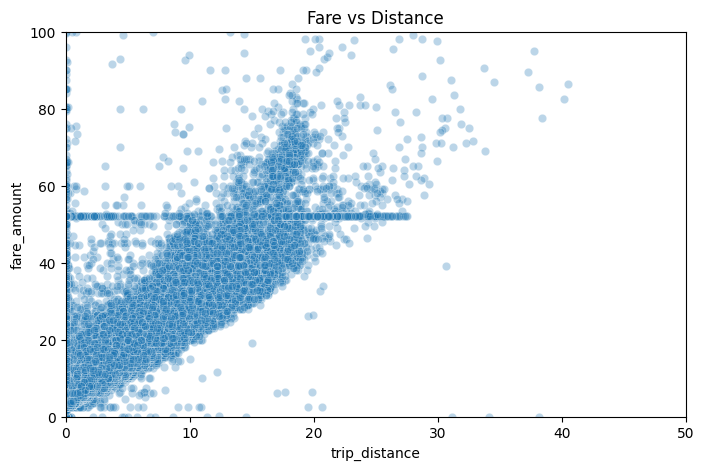

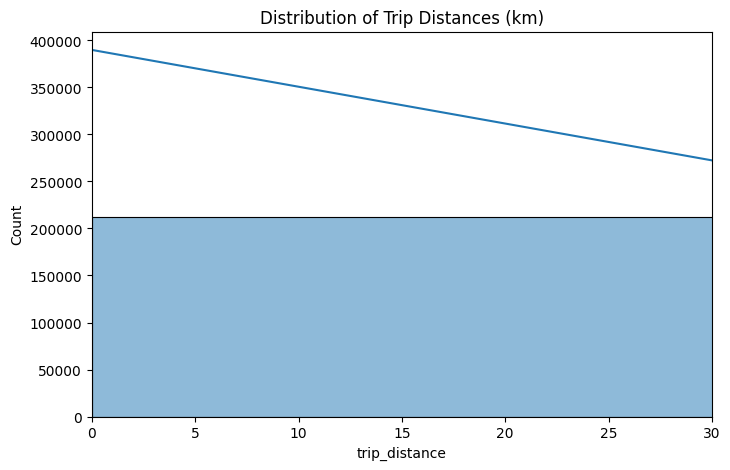

C:\Users\Darnish S\AppData\Local\Temp\ipykernel_27308\766991452.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="pickup_hour", y="fare_amount", data=df, estimator="mean", ci=None)


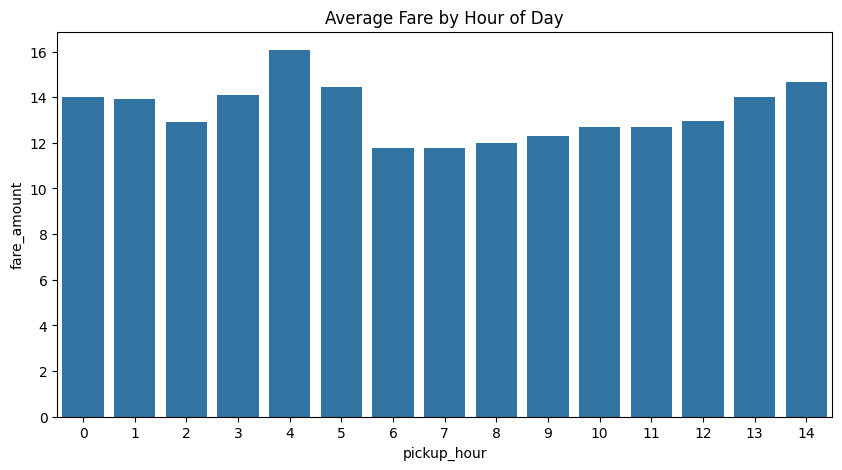

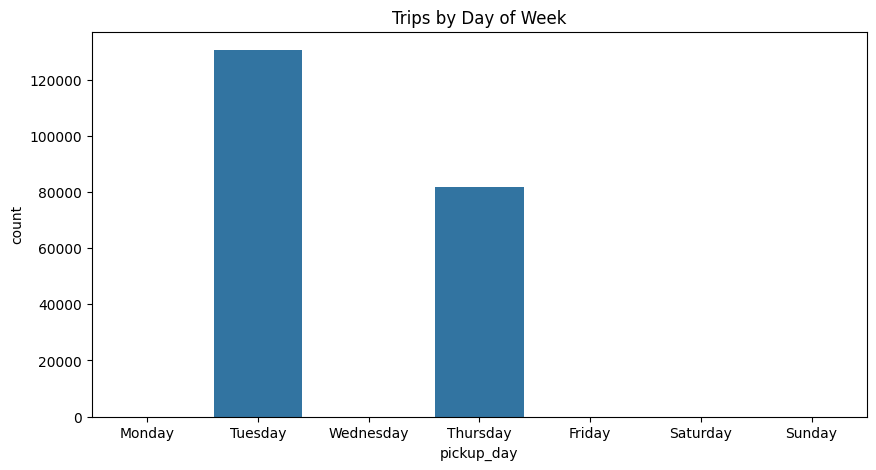

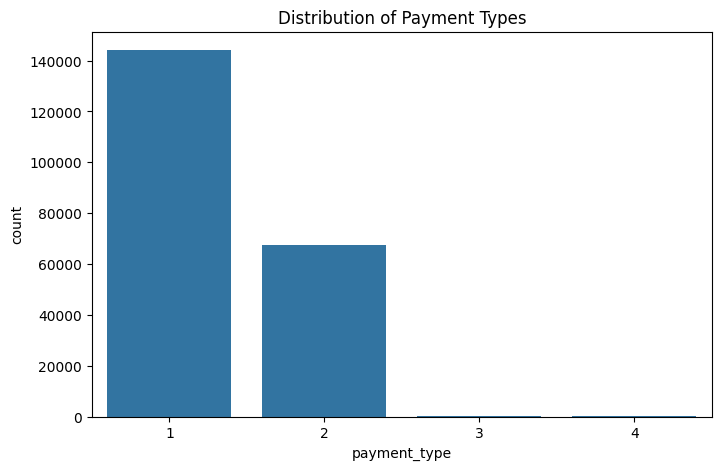

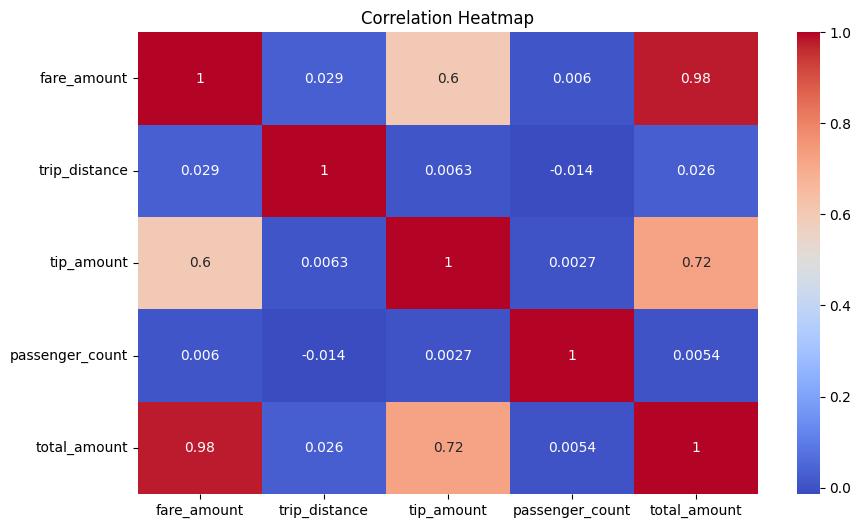

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Fare vs Distance
plt.figure(figsize=(8,5))
sns.scatterplot(x="trip_distance", y="fare_amount", data=df, alpha=0.3)
plt.ylim(0,100)   # focus on reasonable fares
plt.xlim(0,50)    # focus on reasonable distances
plt.title("Fare vs Distance")
plt.show()

# 2️⃣ Distribution of Trip Distances
plt.figure(figsize=(8,5))
sns.histplot(df["trip_distance"], bins=50, kde=True)
plt.xlim(0,30)
plt.title("Distribution of Trip Distances (km)")
plt.show()

# 3️⃣ Average Fare by Hour of Day
plt.figure(figsize=(10,5))
sns.barplot(x="pickup_hour", y="fare_amount", data=df, estimator="mean", ci=None)
plt.title("Average Fare by Hour of Day")
plt.show()

# 4️⃣ Trip Volume by Day of Week
plt.figure(figsize=(10,5))
sns.countplot(x="pickup_day", data=df,
              order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Trips by Day of Week")
plt.show()

# 5️⃣ Payment Type Distribution
plt.figure(figsize=(8,5))
sns.countplot(x="payment_type", data=df)
plt.title("Distribution of Payment Types")
plt.show()

# 6️⃣ Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df[["fare_amount","trip_distance","tip_amount",
                "passenger_count","total_amount"]].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [19]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer

# ---------------------------
# Handle Outliers using Z-Score
# ---------------------------
z_scores = np.abs(stats.zscore(df[['fare_amount','trip_distance','tip_amount','total_amount']]))
df = df[(z_scores < 3).all(axis=1)]  # remove extreme outliers

# ---------------------------
# Fix Skewness with Power Transform (Yeo-Johnson)
# ---------------------------
continuous_features = ['fare_amount','trip_distance','tip_amount','total_amount']
pt = PowerTransformer(method='yeo-johnson')
df[continuous_features] = pt.fit_transform(df[continuous_features])

# ---------------------------
# Encode categorical variables
# ---------------------------
cat_features = ['store_and_fwd_flag','payment_type','pickup_day','pickup_am_pm']
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# ---------------------------
# Feature scaling
# ---------------------------
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

print("✅ Data Transformation Done. Shape:", df.shape)


✅ Data Transformation Done. Shape: (204171, 26)


C:\Users\Darnish S\AppData\Local\Temp\ipykernel_27308\3744680968.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[continuous_features] = pt.fit_transform(df[continuous_features])
C:\Users\Darnish S\AppData\Local\Temp\ipykernel_27308\3744680968.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
C:\Users\Darnish S\AppData\Local\Temp\ipykernel_27308\3744680968.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

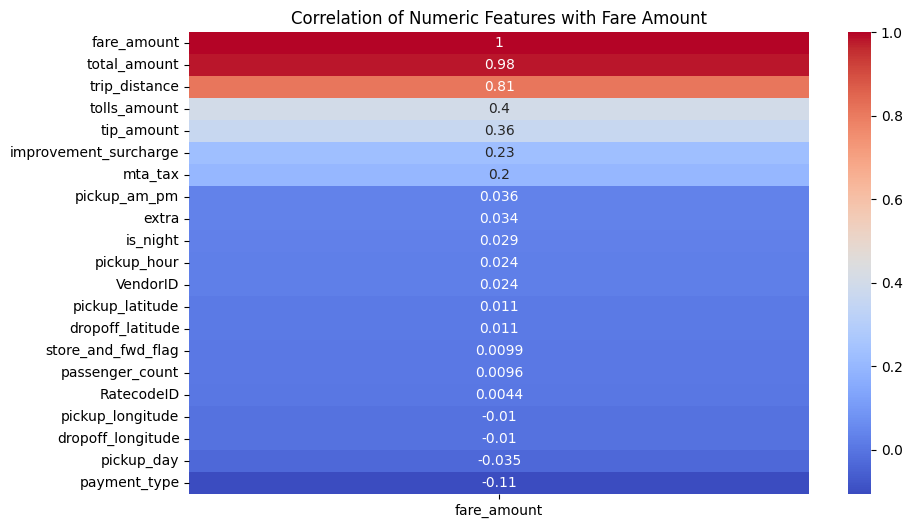


ANOVA F-test Results:
                   Feature       F_score       p_value
14           total_amount  5.673776e+06  0.000000e+00
19          trip_distance  3.928143e+05  0.000000e+00
12           tolls_amount  3.877178e+04  0.000000e+00
11             tip_amount  3.049474e+04  0.000000e+00
13  improvement_surcharge  1.138573e+04  0.000000e+00
10                mta_tax  8.451858e+03  0.000000e+00
8            payment_type  2.340905e+03  0.000000e+00
17           pickup_am_pm  2.669315e+02  5.778800e-60
15             pickup_day  2.509959e+02  1.702418e-56
9                   extra  2.418597e+02  1.661698e-54
18               is_night  1.668799e+02  3.678233e-38
16            pickup_hour  1.161488e+02  4.484072e-27
0                VendorID  1.137570e+02  1.496927e-26
3         pickup_latitude  2.491354e+01  6.000894e-07
7        dropoff_latitude  2.359559e+01  1.189472e-06
6       dropoff_longitude  2.215516e+01  2.516436e-06
2        pickup_longitude  2.202688e+01  2.690321e-06
5   

C:\Users\Darnish S\AppData\Local\Temp\ipykernel_27308\1767116526.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=rf_importances.head(15), palette="viridis")


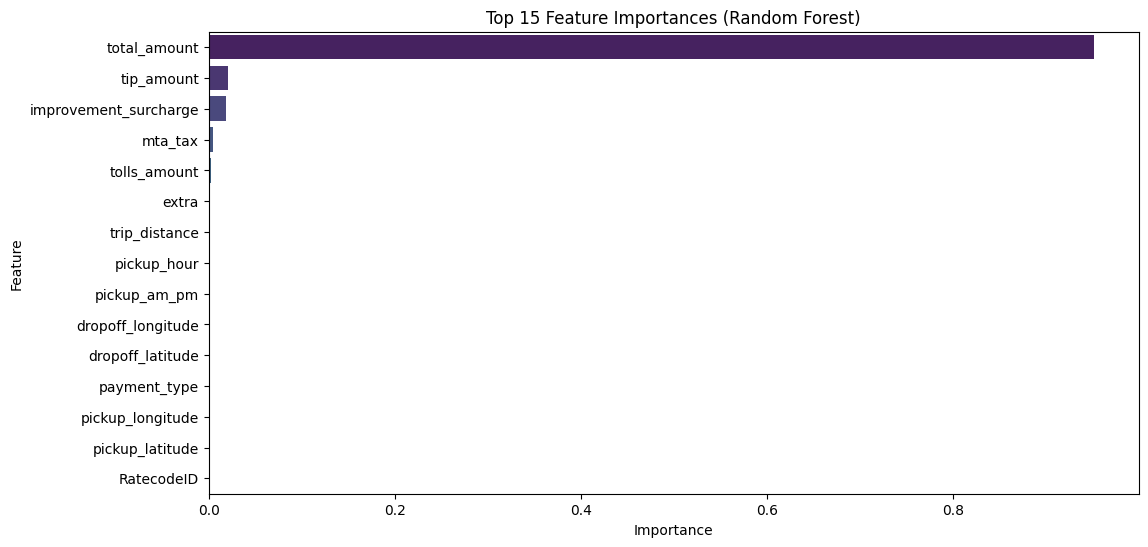

In [23]:
# ==============================
# Step 6: Feature Selection (Fixed for RF)
# ==============================

from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

target = "fare_amount"

# Drop datetime if it exists
if "pickup_datetime" in df.columns:
    df = df.drop(columns=["pickup_datetime"])

features = df.drop(columns=[target])

# ==============================
# 1️⃣ Correlation with Target (numeric only)
# ==============================
numeric_features = features.select_dtypes(include=[np.number]).columns.tolist()

corr_matrix = df[numeric_features + [target]].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix[[target]].sort_values(by=target, ascending=False), 
            annot=True, cmap="coolwarm")
plt.title("Correlation of Numeric Features with Fare Amount")
plt.show()

# ==============================
# 2️⃣ ANOVA F-test (numeric only)
# ==============================
X_num = df[numeric_features]
y = df[target]

f_scores, p_values = f_regression(X_num, y)
anova_results = pd.DataFrame({
    "Feature": numeric_features,
    "F_score": f_scores,
    "p_value": p_values
}).sort_values("F_score", ascending=False)

print("\nANOVA F-test Results:\n", anova_results)

# ==============================
# 3️⃣ Random Forest Feature Importance
# ==============================
X = features.select_dtypes(include=[np.number])   # ensure numeric only
y = df[target]

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

rf_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

print("\nRandom Forest Feature Importances:\n", rf_importances)

# Plot top 15
plt.figure(figsize=(12,6))
sns.barplot(x="Importance", y="Feature", data=rf_importances.head(15), palette="viridis")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


In [28]:
df = pd.read_csv(r"C:\Users\Darnish S\OneDrive\Desktop\tripfare_project\data\taxi_fare_clean.csv")
# Convert datetime columns to pandas datetime
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

# Extract pickup datetime features
df["pickup_year"] = df["tpep_pickup_datetime"].dt.year
df["pickup_month"] = df["tpep_pickup_datetime"].dt.month
df["pickup_day"] = df["tpep_pickup_datetime"].dt.day
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
df["pickup_dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek

# Trip duration in minutes (dropoff - pickup)
df["trip_duration_min"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60

# Drop original datetime columns
df = df.drop(columns=["tpep_pickup_datetime", "tpep_dropoff_datetime"])


In [29]:
numeric_features = df.drop(columns=["fare_amount"]).select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.drop(columns=["fare_amount"]).select_dtypes(include=["object"]).columns.tolist()

print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)


Numeric Features: ['VendorID', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'RatecodeID', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_dayofweek', 'trip_duration_min']
Categorical Features: ['store_and_fwd_flag']



📊 Model Performance (No Leakage):
                         R2         MSE       RMSE       MAE
Linear Regression -0.046886  135.143837  11.625138  6.390807
Ridge Regression  -0.046883  135.143431  11.625121  6.391078
Lasso Regression  -0.046117  135.044491  11.620864  6.398333
Random Forest      0.871770   16.553427   4.068590  0.710129
Gradient Boosting  0.845639   19.926605   4.463923  1.290996


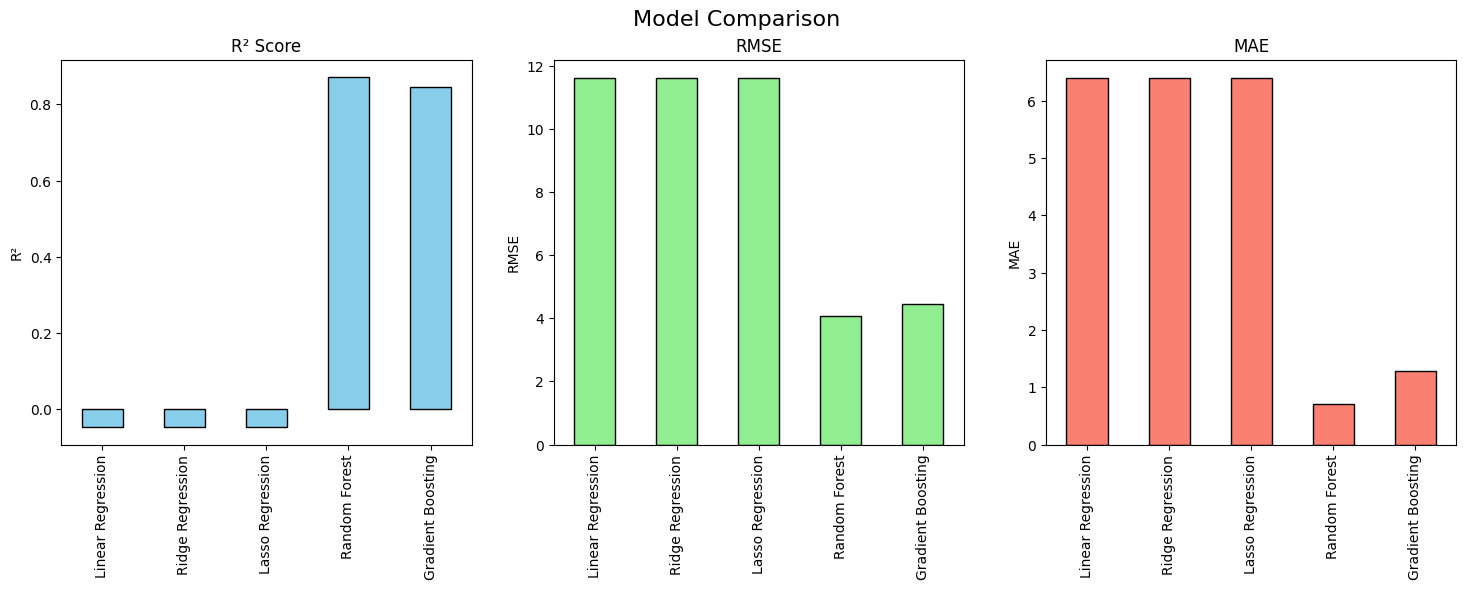

In [35]:
# ===============================
#  Taxi Fare Prediction - 5 Models
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Define Features & Target
# -------------------------------
numeric_features = [
    'VendorID', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
    'RatecodeID', 'dropoff_longitude', 'dropoff_latitude',
    'payment_type', 'trip_duration_min'
]
categorical_features = ['store_and_fwd_flag']   # (optional: encode if needed)

target = "fare_amount"   # <-- make sure your dataset has this column

# Example: assuming df is your dataset
X = df[numeric_features]   # only numeric for now
y = df[target]

# -------------------------------
# Train / Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# Define Models
# -------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42),
    "Lasso Regression": Lasso(alpha=0.01, random_state=42, max_iter=10000),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

# -------------------------------
# Train & Evaluate
# -------------------------------
for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),   # scaling helps linear models
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),  # manual RMSE
        "MAE": mean_absolute_error(y_test, y_pred)
    }

# -------------------------------
# Results Table
# -------------------------------
results_df = pd.DataFrame(results).T
print("\n📊 Model Performance (No Leakage):")
print(results_df)

# -------------------------------
# Visualization
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² Scores
results_df["R2"].plot(kind="bar", ax=axes[0], color="skyblue", edgecolor="black")
axes[0].set_title("R² Score")
axes[0].set_ylabel("R²")

# RMSE
results_df["RMSE"].plot(kind="bar", ax=axes[1], color="lightgreen", edgecolor="black")
axes[1].set_title("RMSE")
axes[1].set_ylabel("RMSE")

# MAE
results_df["MAE"].plot(kind="bar", ax=axes[2], color="salmon", edgecolor="black")
axes[2].set_title("MAE")
axes[2].set_ylabel("MAE")

plt.suptitle("Model Comparison", fontsize=16)
plt.show()


In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# ✅ Train Random Forest with reasonable parameters
rf_best = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_best.fit(X_train, y_train)

# ✅ Predictions
y_pred = rf_best.predict(X_test)

# ✅ Evaluation metrics (manual RMSE)
results = {
    "R2": r2_score(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),  # manual sqrt
    "MAE": mean_absolute_error(y_test, y_pred)
}

print("\n📊 Random Forest (Manual Params) Performance:")
print(pd.DataFrame(results, index=["Random Forest"]))



📊 Random Forest (Manual Params) Performance:
                     R2        MSE      RMSE       MAE
Random Forest  0.871763  16.554259  4.068693  0.774049


In [41]:
import pickle

# Save model
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_best, f)

print("✅ Random Forest model saved as random_forest_model.pkl")


✅ Random Forest model saved as random_forest_model.pkl


In [42]:
# streamlit_app.py
import streamlit as st
import pickle
import numpy as np

# Load trained model
with open("random_forest_model.pkl", "rb") as f:
    model = pickle.load(f)

st.title("🚖 NYC Taxi Trip Duration Prediction")

st.write("Enter trip details to predict estimated trip duration (minutes).")

# User inputs
vendor_id = st.selectbox("Vendor ID", [1, 2])
passenger_count = st.number_input("Passenger Count", min_value=1, max_value=6, value=1)
pickup_longitude = st.number_input("Pickup Longitude", value=-73.985428)
pickup_latitude = st.number_input("Pickup Latitude", value=40.748817)
dropoff_longitude = st.number_input("Dropoff Longitude", value=-73.985428)
dropoff_latitude = st.number_input("Dropoff Latitude", value=40.748817)
rate_code = st.selectbox("Rate Code", [1, 2, 3, 4, 5, 6])
payment_type = st.selectbox("Payment Type", [1, 2, 3, 4, 5, 6])
store_and_fwd_flag = st.selectbox("Store and Forward Flag", ["N", "Y"])

# Encode categorical (same encoding as training)
store_flag = 1 if store_and_fwd_flag == "Y" else 0

# Prepare input
features = np.array([[vendor_id, passenger_count,
                      pickup_longitude, pickup_latitude,
                      rate_code,
                      dropoff_longitude, dropoff_latitude,
                      payment_type, 
                      # trip_duration_min is target, so not included
                      store_flag]])

# Prediction
if st.button("Predict Trip Duration"):
    prediction = model.predict(features)[0]
    st.success(f"🕒 Estimated Trip Duration: {prediction:.2f} minutes")


2025-08-24 13:31:58.380 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-24 13:31:58.494 
  command:

    streamlit run c:\Users\Darnish S\AppData\Local\Programs\Python\Python313\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-08-24 13:31:58.495 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-24 13:31:58.495 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-24 13:31:58.496 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-24 13:31:58.496 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-24 13:31:58.497 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-24 13